In [1]:
import atmospy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# disable warnings for demo purposes
warnings.filterwarnings("ignore")

atmospy.set_theme()

# this tutorial was completed using version:
atmospy.__version__

'0.1.2'

In [2]:
def load_data(month, year, return_just_df_ref = False):
    df = pd.DataFrame()
    df_ref = pd.DataFrame()
    month_year_string = str(year) + '_' + str(month).zfill(2)

    if not return_just_df_ref:
        filename_tail = '@devnode_' + str(year) + '-' + str(month).zfill(2)  + '.csv'

        df_co = pd.read_csv(month_year_string + '/raw_CO-B4' + filename_tail, sep=',')
#        df_nh3 = pd.read_csv(month_year_string + '/raw_NH3-B1' + filename_tail, sep=',')
#        df_no2 = pd.read_csv(month_year_string + '/raw_NO2-B43F' + filename_tail, sep=',')
#        df_ox = pd.read_csv(month_year_string + '/raw_OX-B431' + filename_tail, sep=',')
#        df_pm_opcn3 = pd.read_csv(month_year_string + '/raw_PM-OPCN3' + filename_tail, sep=',')
        df_pm_sps30 = pd.read_csv(month_year_string + '/raw_PM-SPS30' + filename_tail, sep=',')
        df_t = pd.read_csv(month_year_string + '/raw_T_RH_P_BME280' + filename_tail, sep=',')

        # Combining all datasets using the "Čas" column
        df = pd.merge(df_co, df_t, on="Čas")
#        df = pd.merge(df, df_no2, on="Čas")
#        df = pd.merge(df, df_ox, on="Čas")
#        df = pd.merge(df, df_pm_opcn3, on="Čas")
        df = pd.merge(df, df_pm_sps30, on="Čas")

        # Calculating actual values for the WE (working electrode) and AE (auxilary electrode) values
        df["CO"] = df["WE_CO"] - df["AE_CO"] 
#        df["NH3"] = df["WE_NH3"] - df["AE_NH3"] 
#        df["NO2"] = df["WE_NO2"] - df["AE_NO2"] 
#        df["O3"] = df["WE_O3"] - df["AE_O3"]

        df["CO"] = pd.to_numeric(df["CO"], errors='coerce')*4297.516376 -188.11215665209252

        df["PM_10"] = pd.to_numeric(df["PM_10"], errors='coerce')
        
        # Dropping the extra columns (including the pressure - that makes a negligible difference)
        df = df.drop(["WE_CO", "AE_CO", "PM_4"], axis=1)

        # Renaming the "Čas" column
        df = df.rename(columns={
            'Čas': 'Time',
        })
        
        # Converting the time to a datetime
        df['Time'] = pd.to_datetime(df['Time'])

        # 1h shift of the CSV data (CSV seems to be UTC, reference data UTC+1)
        df['Time'] += pd.Timedelta(hours=1)

        # Set 'Time' column as the DataFrame index
        df.set_index('Time', inplace=True)

        # Resample to 1-hour intervals and calculate the mean for each group
        df_hourly_mean = df.resample('1h').mean()

        # Assign the calculated hourly means back to the original DataFrame
        df = df_hourly_mean.reset_index()
 
    # The edited dataset has the "Celkem" values at the end of the data removed
    df_ref = pd.read_excel(month_year_string + "/MS_MarianskeHory_60min_" + month_year_string + "_edited.xlsx")

    df_ref = df_ref.rename(columns={
        'Unnamed: 0': 'Time',
        'Celaskon; 1663_MarHory; WSPE [m/s]': 'WSPE [m/s]',
        'Celaskon; 1663_MarHory; WDIR [deg]': 'WDIR [deg]',
        'Celaskon; 1663_MarHory; HUMI [%]': 'HUMI [%]',
        'Celaskon; 1663_MarHory; PRES [hPa]': 'PRES [hPa]',
        'Celaskon; 1663_MarHory; TEMP [°C]': 'TEMP [°C]',
        'Celaskon; 1663_MarHory; PM10 [ug/m3]': 'PM10 [µg/m3]',
        'Celaskon; 1663_MarHory; O3 [ug/m3]': 'O3 [µg/m3]',
        'Celaskon; 1663_MarHory; SO2 [ug/m3]': 'SO2 [µg/m3]',
        'Celaskon; 1663_MarHory; NO [ug/m3]': 'NO [µg/m3]',
        'Celaskon; 1663_MarHory; NO2 [ug/m3]': 'NO2 [µg/m3]',
        'Celaskon; 1663_MarHory; CO [ug/m3]': 'CO [µg/m3]'
    })

     # Apply the function to the entire column
    df_ref['Time'] = pd.to_datetime(df_ref['Time'], format="%d.%m.%Y %H:%M:%S")

    # Synchronizing the datatypes of "Time" in the datasets
    df_ref['Time'] = df_ref['Time'].dt.tz_localize('UTC')


    if return_just_df_ref:
        return df_ref.sort_values(by='Time')
    else:
        # Merge the two DataFrames on the 'Time' column
        df_merged = pd.merge(df, df_ref, on='Time')

        # Sorting the values by the "Time" attribute
        df_merged.sort_values(by="Time")

        # Check the correlation between 'CO' and 'CO [µg/m3]'
        correlation = df_merged['CO'].diff().corr(df_merged['CO [µg/m3]'].diff())

        #print(f'Correlation between CO and CO [µg/m3]: {correlation}')

        return df_merged.sort_values(by='Time')

def append_data(month, year, df_to_append_to, return_just_df_ref = False):
    df_to_append = load_data(month, year, return_just_df_ref)

    # Combining the datasets
    new_df = pd.concat([df_to_append, df_to_append_to])

    max_time = new_df["Time"].max()
    min_time = new_df["Time"].min()

    print("Maximum Time value:", max_time)
    print("Minimum Time value:", min_time)

    return new_df.sort_values(by='Time')

In [38]:
df = load_data(11, 2023)
#df_ref = load_data(1, 2024, False)   # Loading the reference dataset for the exploratory analysis

df.head(25)
#df_ref.head()
print(df.describe())

                T          RH            p        PM_1        PM_2  \
count  631.000000  631.000000   631.000000  631.000000  631.000000   
mean     5.310865   78.428444   981.030284   15.688024   17.031981   
std      4.762682    8.715018     8.802008   15.108150   16.664545   
min     -4.685778   50.354806   958.952381    0.784028    0.831944   
25%      0.914083   73.248417   976.000000    4.751306    5.067125   
50%      6.017000   80.282167   981.961111   10.289944   10.976601   
75%      8.722445   84.985639   986.640278   21.623903   23.371611   
max     16.700972   92.867306  1001.000000  107.178417  115.617667   

            PM_10          CO  WSPE [m/s]  WDIR [deg]    HUMI [%]  \
count  631.000000  631.000000  720.000000  720.000000  720.000000   
mean    17.582968  189.478420    0.888472  206.748611   91.543056   
std     17.547803  132.669037    0.597252   71.485388   10.429488   
min      0.835611   50.248348    0.000000    0.000000   54.000000   
25%      5.211458  110.3

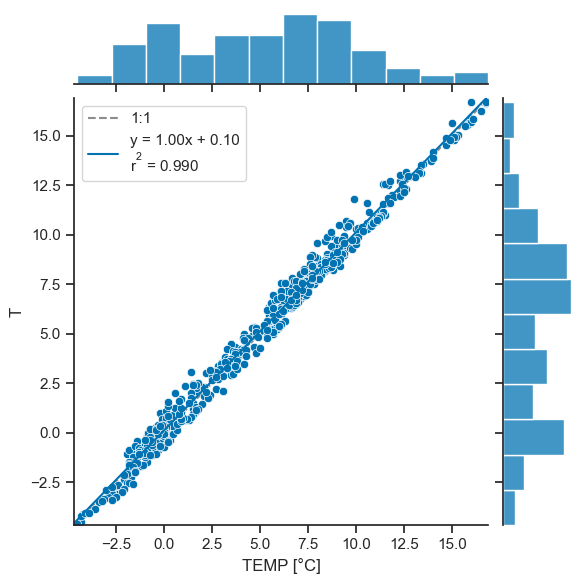

In [39]:
t = atmospy.regplot(
    data=df,
    x="TEMP [°C]", 
    y="T"
)

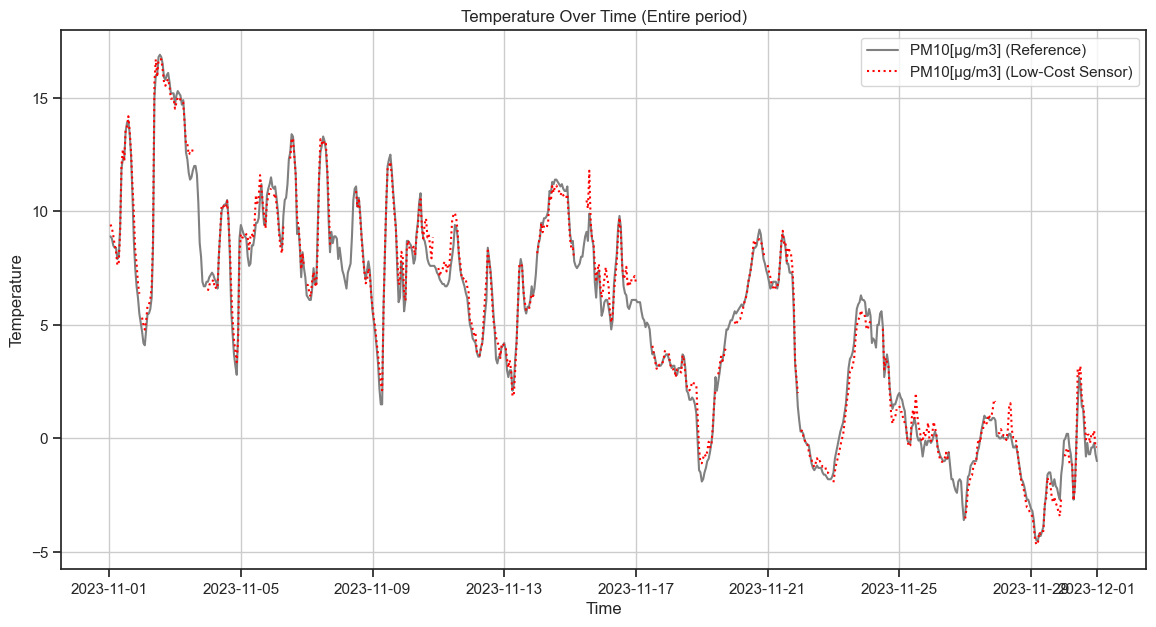

In [40]:
plt.figure(figsize=(14, 7))

plt.plot(df['Time'], df['TEMP [°C]'],  color="grey",label='PM10[µg/m3] (Reference)')
plt.plot(df['Time'], df['T'], color="red", linestyle=":", label='PM10[µg/m3] (Low-Cost Sensor)')

plt.title('Temperature Over Time (Entire period)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

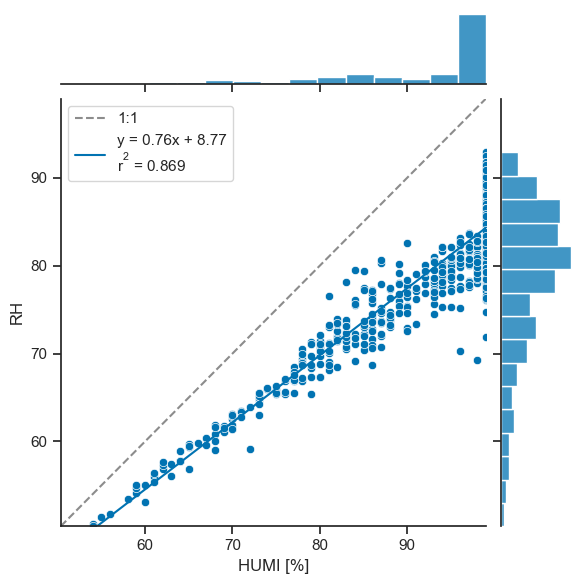

In [41]:
rh = atmospy.regplot(
    data=df,
    x="HUMI [%]", 
    y="RH"
)

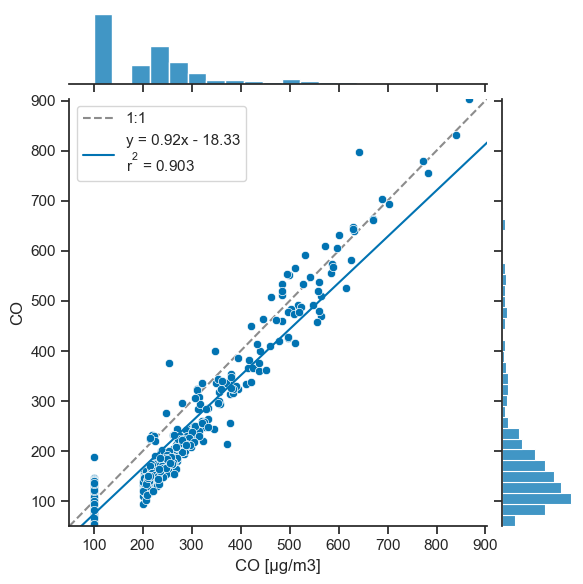

In [42]:
co = atmospy.regplot(
    data=df,
    x="CO [µg/m3]", 
    y="CO"   
)

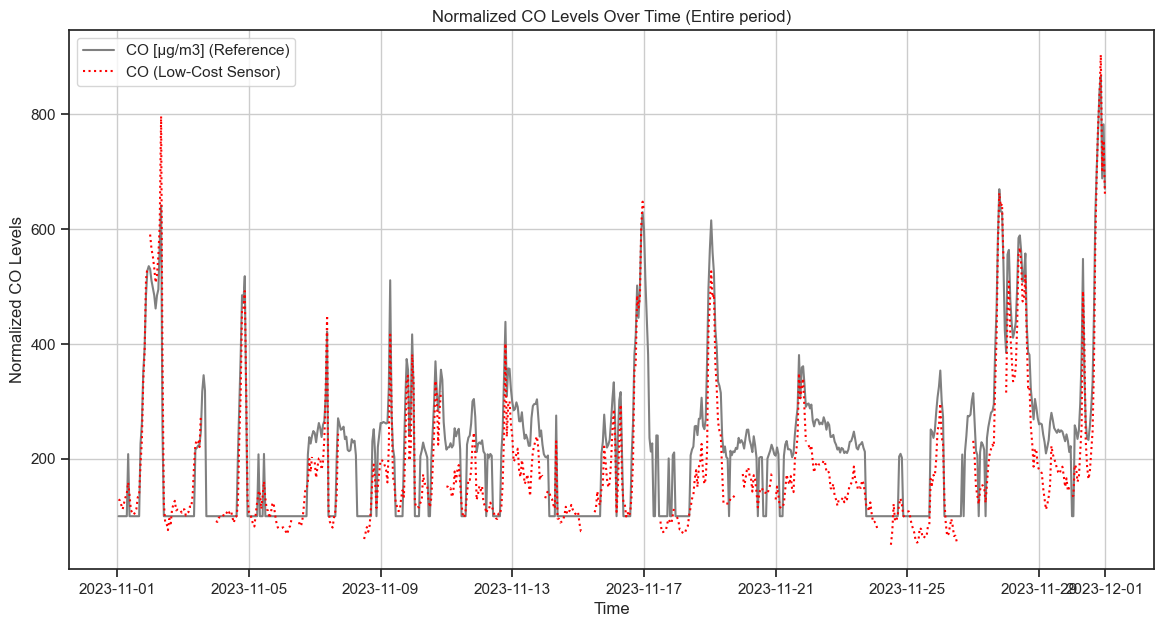

In [43]:
# Plotting
plt.figure(figsize=(14, 7))

plt.plot(df['Time'], df['CO [µg/m3]'],  color="grey",label='CO [µg/m3] (Reference)')
plt.plot(df['Time'], df['CO'], color="red", linestyle=":", label='CO (Low-Cost Sensor)')

plt.title('Normalized CO Levels Over Time (Entire period)')
plt.xlabel('Time')
plt.ylabel('Normalized CO Levels')
plt.legend()
plt.grid(True)
plt.show()

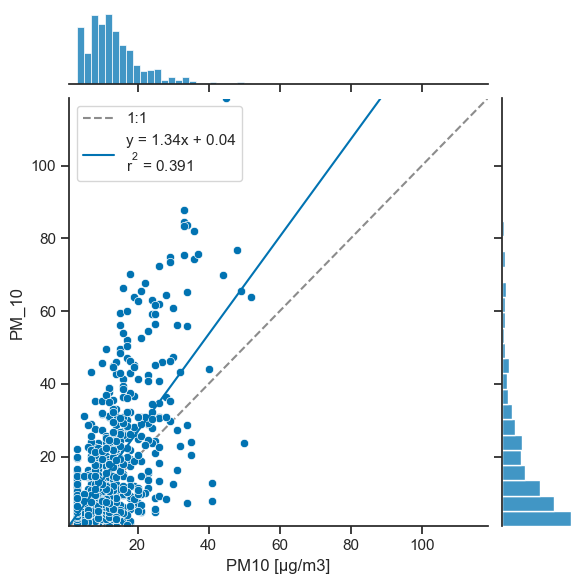

In [44]:
pm = atmospy.regplot(
    data=df,
    x="PM10 [µg/m3]", 
    y="PM_10"   
)

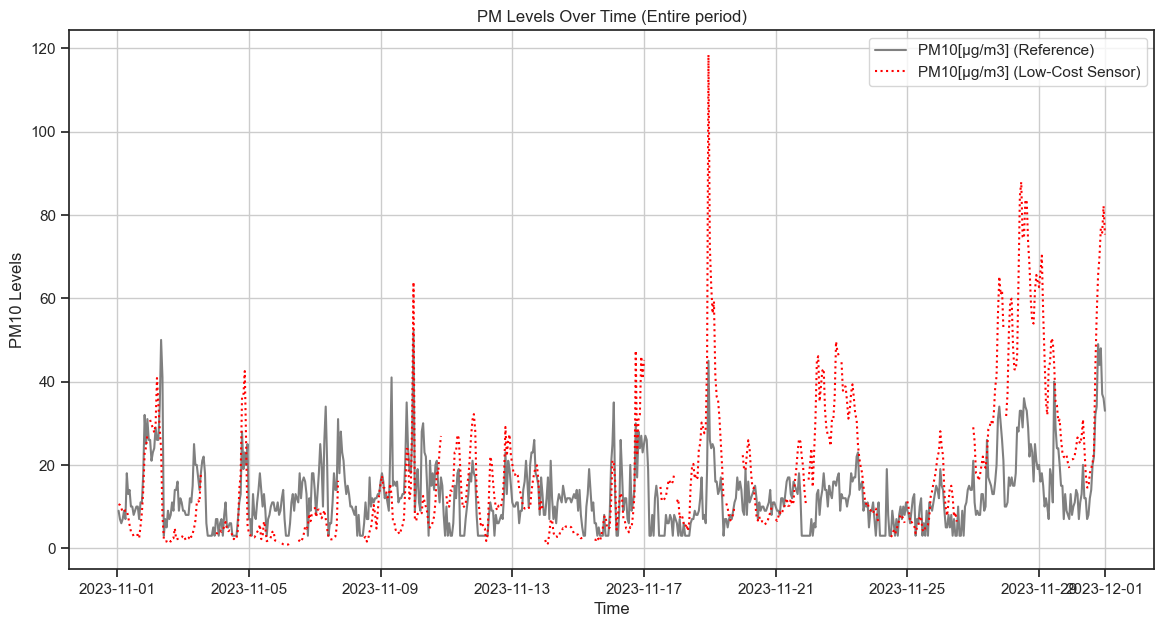

In [45]:
plt.figure(figsize=(14, 7))

plt.plot(df['Time'], df['PM10 [µg/m3]'],  color="grey",label='PM10[µg/m3] (Reference)')
plt.plot(df['Time'], df['PM_10'], color="red", linestyle=":", label='PM10[µg/m3] (Low-Cost Sensor)')

plt.title('PM Levels Over Time (Entire period)')
plt.xlabel('Time')
plt.ylabel('PM10 Levels')
plt.legend()
plt.grid(True)
plt.show()